<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/rating_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Libaries
import os
import sys
import json
import pandas as pd
import numpy as np
import importlib
import pandas_gbq


from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata

# Install scikit learn
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
# Install Trueskill library
!pip install trueskill
from trueskill import Rating, rate_1vs1

  Preparing metadata (setup.py) ... done
  Created wheel for trueskill: filename=trueskill-0.4.5-py3-none-any.whl size=18048 sha256=60ea33a887af19cd0e4d1f8b1868e3d90ee34239dd746244aeb16d8ea2bb7c50
  Stored in directory: /root/.cache/pip/wheels/b9/4f/29/c79f0a2956775524c7a23638ac2b6fbb516c680f8e5eed9b53
Successfully built trueskill


In [3]:
# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')


# Import user defined python functions
import model_evaluation_functions
import ratings_functions
importlib.reload(model_evaluation_functions)
importlib.reload(ratings_functions)

from ratings_functions import *
from model_evaluation_functions import *


Mounted at /content/drive


In [4]:
# Authentication credentials and keys

# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [5]:
def load_predictions_and_ratings_to_bigquery(client, predictions_df, fold_ratings_df, ratings_model):

  # Load predictions to Big Query
  # Specify the target table
  load_dataset_name = 'analysis_layer'
  load_table_name = 'ratings_predictions'
  load_table_ref = f"{load_dataset_name}.{load_table_name}"

  # Delete predicitons method already inserted
  delete_query = f"DELETE FROM `{load_dataset_name}.{load_table_name}` WHERE ratings_model = '{ratings_model}'"
  delete_job = client.query(delete_query)
  delete_result = delete_job.result()
  predictions_total_rows_deleted = delete_result.num_dml_affected_rows
  print(f"Big Query target predictions table {load_dataset_name}.{load_table_name} rows deleted: {predictions_total_rows_deleted}")

  # Insert predictions for ratings model data to the existing table
  job_config = bigquery.LoadJobConfig(
          write_disposition="WRITE_APPEND")
  load_job = client.load_table_from_dataframe(
          predictions_df, load_table_ref, job_config=job_config)
  # Wait for the job to complete
  load_job.result()
  predictions_num_rows_inserted = load_job.output_rows
  print(f"{predictions_num_rows_inserted} rows appended to predictions table {load_table_ref} successfully.")

  # Load fold ratings to Big Query

  # Specify the target table
  load_dataset_name = 'analysis_layer'
  load_table_name = 'ratings'
  load_table_ref = f"{load_dataset_name}.{load_table_name}"

  # Delete ratings method already inserted
  delete_query = f"DELETE FROM `{load_dataset_name}.{load_table_name}` WHERE ratings_model = '{ratings_model}'"
  delete_job = client.query(delete_query)
  delete_result = delete_job.result()
  ratings_total_rows_deleted = delete_result.num_dml_affected_rows
  print(f"Big Query target ratings table {load_dataset_name}.{load_table_name} rows deleted: {ratings_total_rows_deleted}")


  # Insert ratings for ratings model data to the existing table
  job_config = bigquery.LoadJobConfig(
          write_disposition="WRITE_APPEND")
  load_job = client.load_table_from_dataframe(
          ratings_df, load_table_ref, job_config=job_config)

  load_job.result()  # Wait for the job to complete

  ratings_num_rows_inserted = load_job.output_rows
  print(f"{ratings_num_rows_inserted} rows appended to ratings table {load_table_ref} successfully.")

  return


In [6]:
# FA Cup Data 13 season from 08/09 to 21/20

fa_cup_scores = """
    SELECT * FROM preparation_layer.view_fa_cup_scores WHERE season_year NOT IN ('21/22', '22/23') ORDER BY sort_order ASC
"""

fa_cup_scores_df = client.query(fa_cup_scores).to_dataframe()
display(fa_cup_scores_df)

# Results & Rank Dataframes
all_ranks_df = pd.DataFrame(columns=['team_no','fold_number'])
display(all_ranks_df)
#def create_all_ranks_df():
 #   global all_ranks_df
  #  all_ranks_df = pd.DataFrame(columns=['team_no'])

#create_all_ranks_df()
#display(all_ranks_df)

all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)



,match_id,match_date,home_team_no,home_team_name,home_team_league_level,home_team_score,away_team_no,away_team_name,away_team_league_level,away_team_score,actual_winning_team_no,actual_losing_team_no,home_win,away_win,actual_upset,sort_order,match_count
0,1428623,2009-01-03,27,Preston North End,2,0,1,Liverpool,1,2,1,27,0,1,0,1,1
1,505337,2010-01-03,1,Chelsea,1,5,34,Watford,2,0,1,34,1,0,0,1,1
2,1138603,2015-01-04,1,Chelsea,1,3,25,Watford,2,0,1,25,1,0,0,1,1
3,1345813,2017-01-08,1,Chelsea,1,4,48,Peterborough United,3,1,1,48,1,0,0,1,1
4,201912,2021-01-09,1,Manchester United,1,1,25,Watford,2,0,1,25,1,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,721706,2023-01-07,59,Grimsby Town,4,1,54,Burton Albion,3,0,59,54,1,0,1,54,1
346,507052,2010-01-02,60,Torquay United,4,0,55,Brighton & Hove Albion,3,1,55,60,0,1,0,55,1
347,1349585,2017-01-07,55,Wycombe Wanderers,4,2,64,Stourbridge,6,1,55,64,1,0,0,55,1
348,476038,2010-01-19,57,Notts County,4,2,64,Forest Green Rovers,5,1,57,64,1,0,0,57,1


,team_no,fold_number


,metric_id,metric


Fold 1/5
Train data size: 280
Test data size: 70
basic_position
<function basic_position_ratings at 0x7c975226e290>
[(1, 1.0), (2, 0.5), (3, 0.3333333333333333), (4, 0.25), (5, 0.2), (6, 0.16666666666666666), (7, 0.14285714285714285), (8, 0.125), (9, 0.1111111111111111), (10, 0.1), (11, 0.09090909090909091), (12, 0.08333333333333333), (13, 0.07692307692307693), (14, 0.07142857142857142), (15, 0.06666666666666667), (16, 0.0625), (17, 0.058823529411764705), (18, 0.05555555555555555), (19, 0.05263157894736842), (20, 0.05), (21, 0.047619047619047616), (22, 0.045454545454545456), (23, 0.043478260869565216), (24, 0.041666666666666664), (25, 0.04), (26, 0.038461538461538464), (27, 0.037037037037037035), (28, 0.03571428571428571), (29, 0.034482758620689655), (30, 0.03333333333333333), (31, 0.03225806451612903), (32, 0.03125), (33, 0.030303030303030304), (34, 0.029411764705882353), (35, 0.02857142857142857), (36, 0.027777777777777776), (37, 0.02702702702702703), (38, 0.02631578947368421), (39, 

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,basic_position,1,505337,1,1,34,2,1.000000,0.029412,1,1,0,0,0.725237
2,basic_position,1,813766,27,2,2,1,0.037037,0.500000,2,2,0,0,0.613717
3,basic_position,1,1061075,2,1,26,2,0.500000,0.038462,2,2,0,0,0.613379
4,basic_position,1,1620324,2,1,50,3,0.500000,0.020000,2,2,0,0,0.617748
5,basic_position,1,817437,3,1,33,2,0.333333,0.030303,3,3,0,0,0.575183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,basic_position,5,1349449,61,5,46,3,0.016393,0.021739,46,46,0,0,0.501336
347,basic_position,5,836539,47,3,64,6,0.021277,0.015625,47,47,0,0,0.501413
348,basic_position,5,1061094,59,4,47,3,0.016949,0.021277,47,47,0,0,0.501082
349,basic_position,5,949974,64,4,48,3,0.015625,0.020833,48,64,1,0,0.501302


,accuracy
1,0.728571
2,0.728571
3,0.714286
4,0.714286
5,0.714286


,ratings_model,fold_number,team_no,rating,rank
320,basic_position,0,1,1.000000,1
0,basic_position,1,1,1.000000,1
4,basic_position,2,1,1.000000,1
2,basic_position,3,1,1.000000,1
1,basic_position,4,1,1.000000,1
...,...,...,...,...,...
317,basic_position,1,64,0.015625,64
316,basic_position,2,64,0.015625,64
318,basic_position,3,64,0.015625,64
315,basic_position,4,64,0.015625,64


Mean Upset Accuracy: 0.7200
Standard Deviation of Upset Accuracy: 0.0070
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
350 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position
0,1,0,1
1,1,1,1
2,1,2,1
3,1,3,1
4,1,4,1
...,...,...,...
379,64,1,64
380,64,2,64
381,64,3,64
382,64,4,64


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,metric_id,metric,basic_position
0,1,Cross-validation Accuracy,0.720
1,2,Cross-validation Standard Deviation,0.007
2,3,Overall Accuracy,0.720
3,4,Confusion Matrix - True Negative (Class 0),252.000
4,5,Confusion Matrix - False Positive (Class 1),0.000
5,6,Confusion Matrix - False Negative (Class 0),98.000
6,7,Confusion Matrix - True Positive (Class 1),0.000
7,8,Precision (Class 0),0.720
8,9,Recall (Class 0),1.000
9,10,F1-score (Class 0),0.837


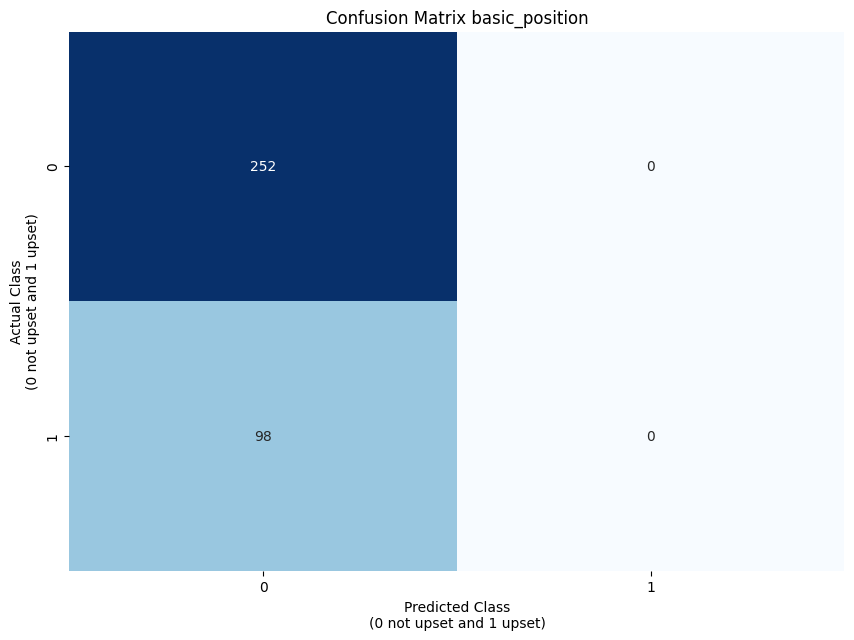

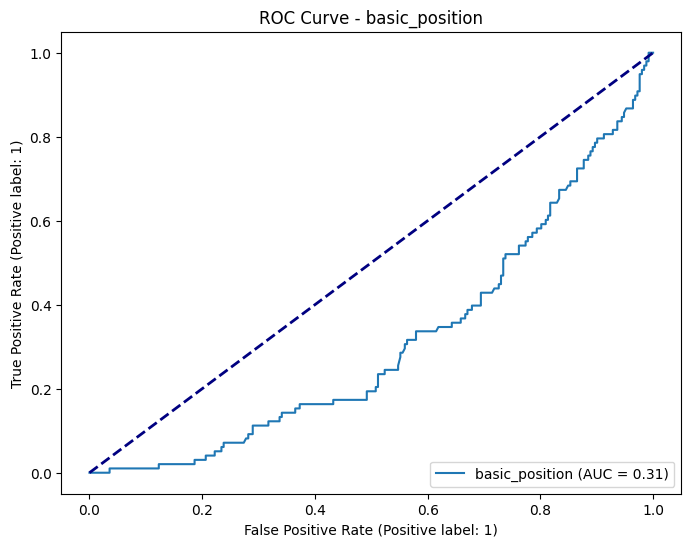

In [7]:
# Basic Position Ratings
ratings_model = 'basic_position'
ratings_function = basic_position_ratings
num_folds = 5

# Call ratings function and run cross validation

results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)


# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)



Fold 1/5
Train data size: 280
Test data size: 70
massey
<function massey_ratings at 0x7c975226dfc0>
280
[(1, 2.6375318791499396), (2, 2.463716456466684), (3, 2.86319241551721), (4, 2.097696975728056), (5, 1.3897807574688419), (6, 2.0244629957246456), (7, -1.5399693713973075), (8, 0.8471544977502906), (9, 0.4671002162057175), (10, 1.354523987305706), (11, -0.7937515565306581), (12, 1.2232609835566814), (13, 0.07623060023193025), (14, 0.10252189705403905), (15, 0.6243088906533731), (16, -0.009109593129228133), (17, 1.023338406404839), (18, 0.957290884292905), (19, -0.5888274184462392), (20, 0.7810190284248859), (21, 0.1937309553006252), (22, 0.04361726932622944), (23, -0.9600568292961948), (24, 1.232599369662498), (25, 1.387652215539733), (26, -1.0028823465375978), (27, 0.24743367479085876), (28, 0.8487866818727837), (29, -1.1366731623297301), (30, 0.9759425417156191), (31, -0.5734218949981884), (32, 0.3812994153650466), (33, -0.041710944313885105), (34, -0.18324950469603657), (35, -1.77

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,massey,1,505337,1,1,34,2,2.637532,-0.183250,1,1,0,0,0.943789
2,massey,1,813766,27,2,2,1,0.247434,2.463716,2,2,0,0,0.901702
3,massey,1,1061075,2,1,26,2,2.463716,-1.002882,2,2,0,0,0.969722
4,massey,1,1620324,2,1,50,3,2.463716,-1.108190,2,2,0,0,0.972666
5,massey,1,817437,3,1,33,2,2.863192,-0.041711,3,3,0,0,0.948088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,massey,5,1349449,61,5,46,3,-1.217229,-0.403746,46,46,0,0,0.692851
347,massey,5,836539,47,3,64,6,0.155200,-1.320809,47,47,0,0,0.813969
348,massey,5,1061094,59,4,47,3,-0.198612,0.155200,47,47,0,0,0.587542
349,massey,5,949974,64,4,48,3,-1.320809,-0.866617,48,64,1,0,0.611635


,accuracy
1,0.642857
2,0.657143
3,0.585714
4,0.714286
5,0.685714


,ratings_model,fold_number,team_no,rating,rank
320,massey,0,1,3.053288,1
0,massey,1,1,2.637532,2
4,massey,2,1,2.862386,2
2,massey,3,1,2.828779,1
1,massey,4,1,3.907860,1
...,...,...,...,...,...
317,massey,1,64,-0.964977,50
316,massey,2,64,-1.328998,61
318,massey,3,64,-1.127554,55
315,massey,4,64,-1.171152,54


Mean Upset Accuracy: 0.6571
Standard Deviation of Upset Accuracy: 0.0433
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
350 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey
0,1,0,1,1
1,1,1,1,2
2,1,2,1,2
3,1,3,1,1
4,1,4,1,1
...,...,...,...,...
379,64,1,64,50
380,64,2,64,61
381,64,3,64,55
382,64,4,64,54


,metric_id,metric,basic_position,massey
0,1,Cross-validation Accuracy,0.720,0.657
1,2,Cross-validation Standard Deviation,0.007,0.043
2,3,Overall Accuracy,0.720,0.657
3,4,Confusion Matrix - True Negative (Class 0),252.000,208.000
4,5,Confusion Matrix - False Positive (Class 1),0.000,44.000
5,6,Confusion Matrix - False Negative (Class 0),98.000,76.000
6,7,Confusion Matrix - True Positive (Class 1),0.000,22.000
7,8,Precision (Class 0),0.720,0.732
8,9,Recall (Class 0),1.000,0.825
9,10,F1-score (Class 0),0.837,0.776


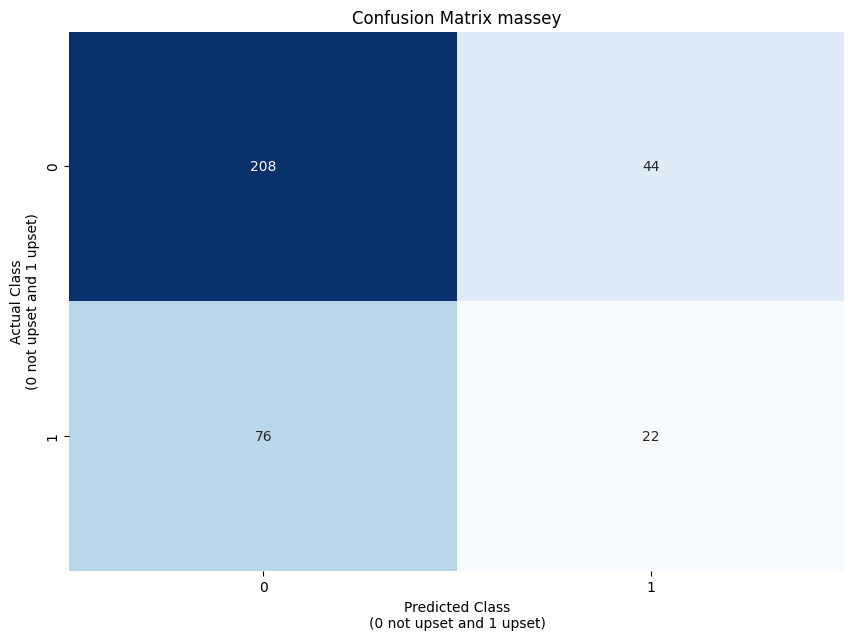

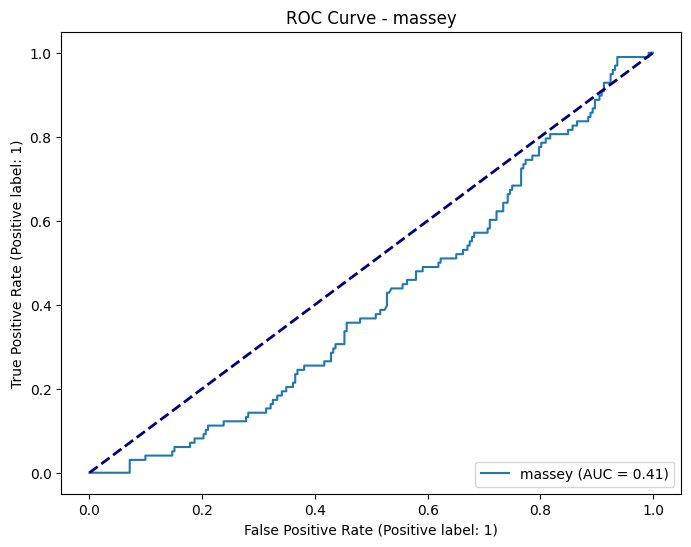

In [8]:
# Massey Ratings
ratings_model = 'massey'
ratings_function = massey_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

Fold 1/5
Train data size: 280
Test data size: 70
colley
<function colley_ratings at 0x7c975226e050>
280
[(1, 0.871462738717925), (2, 0.7825657189379046), (3, 0.8454608822740857), (4, 0.7788697742269967), (5, 0.7431394968576787), (6, 0.7476324598939216), (7, 0.28343394750609285), (8, 0.7373637870864926), (9, 0.5937401626798664), (10, 0.8426193269664849), (11, 0.34404721245394576), (12, 0.7755365701306102), (13, 0.6932823412810162), (14, 0.5504949562371624), (15, 0.763745880808158), (16, 0.5796863771563188), (17, 0.5353795005747933), (18, 0.6147240984971741), (19, 0.34307404332065966), (20, 0.6936064259783973), (21, 0.4236482477845598), (22, 0.4334867631563807), (23, 0.3847711038275224), (24, 0.7749348740696349), (25, 0.6490866640255115), (26, 0.2831910023964274), (27, 0.5468446695351099), (28, 0.790001886504275), (29, 0.2621291592719087), (30, 0.5459492340039054), (31, 0.31902165938916205), (32, 0.5098601293398488), (33, 0.47237335427311106), (34, 0.39327596941735493), (35, 0.2159434789

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,colley,1,505337,1,1,34,2,0.871463,0.393276,1,1,0,0,0.617320
2,colley,1,813766,27,2,2,1,0.546845,0.782566,2,2,0,0,0.558659
3,colley,1,1061075,2,1,26,2,0.782566,0.283191,2,2,0,0,0.622312
4,colley,1,1620324,2,1,50,3,0.782566,0.375102,2,2,0,0,0.600479
5,colley,1,817437,3,1,33,2,0.845461,0.472373,3,3,0,0,0.592205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,colley,5,1349449,61,5,46,3,0.277768,0.702418,46,46,0,0,0.604595
347,colley,5,836539,47,3,64,6,0.461261,0.191336,47,47,0,0,0.567074
348,colley,5,1061094,59,4,47,3,0.547976,0.461261,59,47,0,1,0.521665
349,colley,5,949974,64,4,48,3,0.191336,0.331460,48,64,1,0,0.534974


,accuracy
1,0.657143
2,0.714286
3,0.614286
4,0.714286
5,0.657143


,ratings_model,fold_number,team_no,rating,rank
321,colley,0,1,0.845262,2
0,colley,1,1,0.871463,1
4,colley,2,1,0.890476,1
2,colley,3,1,0.789798,5
1,colley,4,1,0.797418,4
...,...,...,...,...,...
317,colley,1,64,0.174437,63
316,colley,2,64,0.170958,64
318,colley,3,64,0.234023,61
315,colley,4,64,0.203593,63


Mean Upset Accuracy: 0.6714
Standard Deviation of Upset Accuracy: 0.0383
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
350 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley
0,1,0,1,1,2
1,1,1,1,2,1
2,1,2,1,2,1
3,1,3,1,1,5
4,1,4,1,1,4
...,...,...,...,...,...
379,64,1,64,50,63
380,64,2,64,61,64
381,64,3,64,55,61
382,64,4,64,54,63


,metric_id,metric,basic_position,massey,colley
0,1,Cross-validation Accuracy,0.720,0.657,0.671
1,2,Cross-validation Standard Deviation,0.007,0.043,0.038
2,3,Overall Accuracy,0.720,0.657,0.671
3,4,Confusion Matrix - True Negative (Class 0),252.000,208.000,209.000
4,5,Confusion Matrix - False Positive (Class 1),0.000,44.000,43.000
5,6,Confusion Matrix - False Negative (Class 0),98.000,76.000,72.000
6,7,Confusion Matrix - True Positive (Class 1),0.000,22.000,26.000
7,8,Precision (Class 0),0.720,0.732,0.744
8,9,Recall (Class 0),1.000,0.825,0.829
9,10,F1-score (Class 0),0.837,0.776,0.784


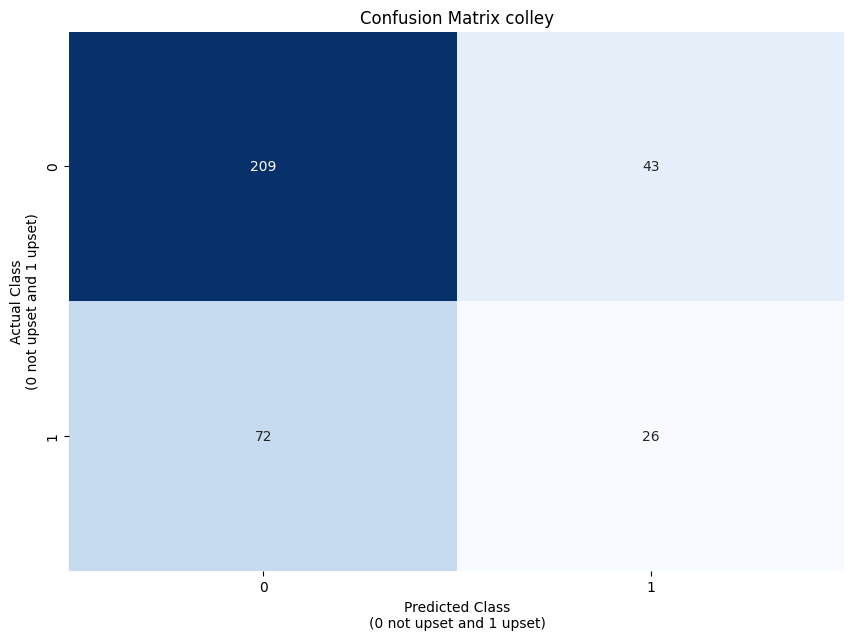

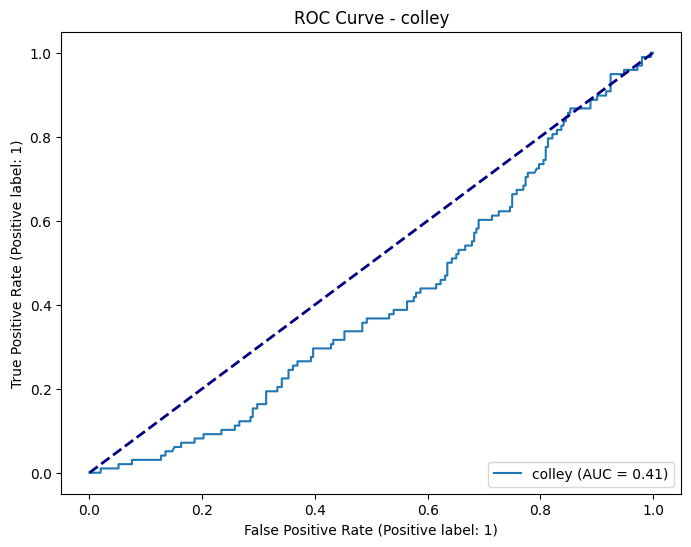

In [9]:
# Colley Ratings
ratings_model = 'colley'
ratings_function = colley_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)



Fold 1/5
Train data size: 280
Test data size: 70
keener
<function keener_ratings at 0x7c975226e0e0>
[(1, 0.13203963865996762), (2, 0.13338236323878805), (3, 0.1334931759608507), (4, 0.1326354618939169), (5, 0.13520703567395856), (6, 0.1344147405936086), (7, 0.12474917680020299), (8, 0.13653116613781457), (9, 0.12864549183397975), (10, 0.13515583471341), (11, 0.12460197076695753), (12, 0.13411042325570863), (13, 0.12886881095382802), (14, 0.12707848317218817), (15, 0.12988576942846794), (16, 0.12711225515178254), (17, 0.12824014891263785), (18, 0.13217380242613835), (19, 0.12522324681352234), (20, 0.13008785706193549), (21, 0.12283117839683345), (22, 0.12264408078141784), (23, 0.11914838201310889), (24, 0.12793178341809708), (25, 0.1295070830930552), (26, 0.12193435596691612), (27, 0.12317613503357074), (28, 0.1311618776942893), (29, 0.11983377448963499), (30, 0.12488210235028208), (31, 0.11729744010966182), (32, 0.1230443360502919), (33, 0.12553341835546428), (34, 0.1249588736048177), 

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,keener,1,505337,1,1,34,2,0.132040,0.124959,1,1,0,0,0.501770
2,keener,1,813766,27,2,2,1,0.123176,0.133382,2,2,0,0,0.502552
3,keener,1,1061075,2,1,26,2,0.133382,0.121934,2,2,0,0,0.502862
4,keener,1,1620324,2,1,50,3,0.133382,0.118323,2,2,0,0,0.503765
5,keener,1,817437,3,1,33,2,0.133493,0.125533,3,3,0,0,0.501990
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,keener,5,1349449,61,5,46,3,0.117175,0.128915,46,46,0,0,0.502935
347,keener,5,836539,47,3,64,6,0.124134,0.118879,47,47,0,0,0.501314
348,keener,5,1061094,59,4,47,3,0.124910,0.124134,59,47,0,1,0.500194
349,keener,5,949974,64,4,48,3,0.118879,0.120508,48,64,1,0,0.500407


,accuracy
1,0.714286
2,0.728571
3,0.642857
4,0.671429
5,0.628571


,ratings_model,fold_number,team_no,rating,rank
329,keener,0,1,0.131936,10
0,keener,1,1,0.132040,10
4,keener,2,1,0.133702,4
2,keener,3,1,0.131955,10
1,keener,4,1,0.128357,15
...,...,...,...,...,...
317,keener,1,64,0.119663,52
316,keener,2,64,0.118222,60
318,keener,3,64,0.118916,53
315,keener,4,64,0.119331,55


Mean Upset Accuracy: 0.6771
Standard Deviation of Upset Accuracy: 0.0390
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
350 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener
0,1,0,1,1,2,10
1,1,1,1,2,1,10
2,1,2,1,2,1,4
3,1,3,1,1,5,10
4,1,4,1,1,4,15
...,...,...,...,...,...,...
379,64,1,64,50,63,52
380,64,2,64,61,64,60
381,64,3,64,55,61,53
382,64,4,64,54,63,55


,metric_id,metric,basic_position,massey,colley,keener
0,1,Cross-validation Accuracy,0.720,0.657,0.671,0.677
1,2,Cross-validation Standard Deviation,0.007,0.043,0.038,0.039
2,3,Overall Accuracy,0.720,0.657,0.671,0.677
3,4,Confusion Matrix - True Negative (Class 0),252.000,208.000,209.000,220.000
4,5,Confusion Matrix - False Positive (Class 1),0.000,44.000,43.000,32.000
5,6,Confusion Matrix - False Negative (Class 0),98.000,76.000,72.000,81.000
6,7,Confusion Matrix - True Positive (Class 1),0.000,22.000,26.000,17.000
7,8,Precision (Class 0),0.720,0.732,0.744,0.731
8,9,Recall (Class 0),1.000,0.825,0.829,0.873
9,10,F1-score (Class 0),0.837,0.776,0.784,0.796


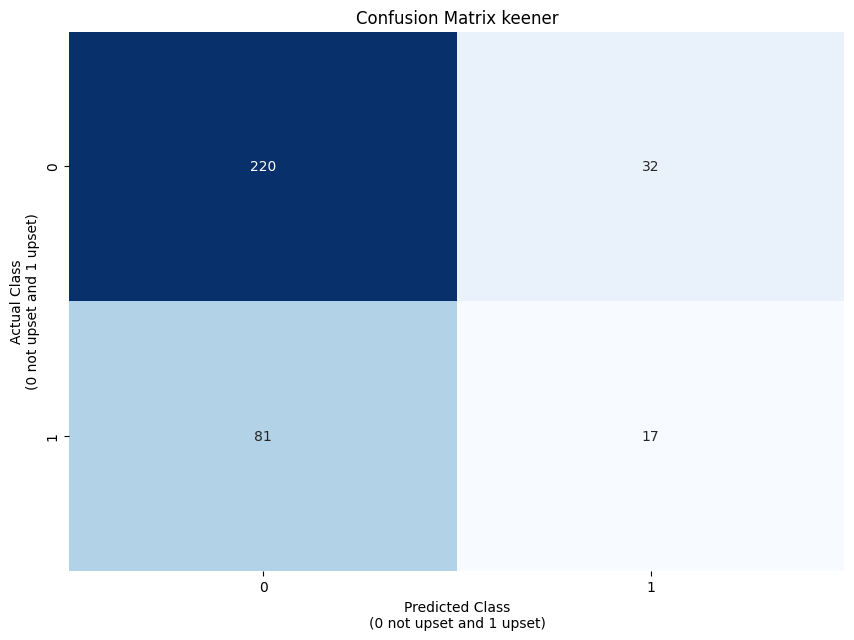

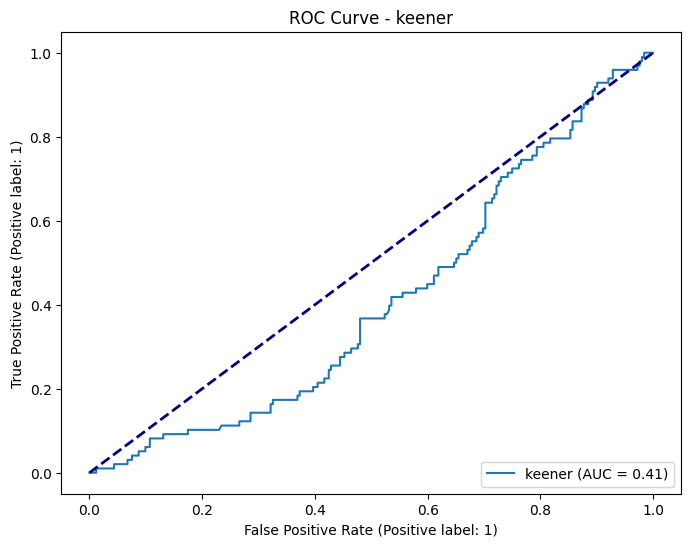

In [10]:
# Keener Ratings
ratings_model = 'keener'
ratings_function = keener_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

Fold 1/5
Train data size: 280
Test data size: 70
trueskill
<function trueskill_ratings at 0x7c975226e170>
[(27, 27.7482586353171), (1, 38.81488355535215), (39, 22.742467696651723), (48, 21.601606195569147), (58, 22.160055931742185), (37, 24.08606337453176), (34, 20.908798422267452), (59, 23.466113890250643), (30, 24.512160309626733), (55, 25.37691635986897), (13, 32.08468913159666), (41, 22.797142927479886), (10, 34.2563078061647), (36, 25.208253417037657), (33, 26.134798939581383), (9, 26.688097621477137), (5, 33.03467557297349), (35, 17.395233934578737), (60, 19.89990405085352), (63, 14.53208121834838), (43, 22.413138936803097), (2, 33.7705194631219), (64, 17.01182657454876), (19, 21.484916036031933), (51, 14.06243752109064), (26, 18.297709914438133), (57, 19.6497328833133), (31, 20.389101581323242), (32, 25.657271330434693), (12, 31.839836803572556), (28, 31.7565946704939), (45, 32.10995078733356), (49, 27.851043568906757), (3, 36.11444349107323), (42, 25.585339482963), (52, 23.9668

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,trueskill,1,505337,1,1,34,2,38.814884,20.908798,1,1,0,0,1.000000
2,trueskill,1,813766,27,2,2,1,27.748259,33.770519,2,2,0,0,0.997582
3,trueskill,1,1061075,2,1,26,2,33.770519,18.297710,2,2,0,0,1.000000
4,trueskill,1,1620324,2,1,50,3,33.770519,22.142253,2,2,0,0,0.999991
5,trueskill,1,817437,3,1,33,2,36.114443,26.134799,3,3,0,0,0.999954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,trueskill,5,1349449,61,5,46,3,17.613780,31.354332,46,46,0,0,0.999999
347,trueskill,5,836539,47,3,64,6,23.828370,16.562112,47,47,0,0,0.999302
348,trueskill,5,1061094,59,4,47,3,25.276594,23.828370,59,47,0,1,0.809725
349,trueskill,5,949974,64,4,48,3,16.562112,22.701009,48,64,1,0,0.997847


,accuracy
1,0.671429
2,0.642857
3,0.657143
4,0.714286
5,0.642857


,ratings_model,fold_number,team_no,rating,rank
320,trueskill,0,1,37.932545,1
1,trueskill,1,1,38.814884,1
0,trueskill,2,1,39.492645,1
2,trueskill,3,1,34.979780,3
3,trueskill,4,1,37.362317,2
...,...,...,...,...,...
315,trueskill,1,64,17.011827,62
316,trueskill,2,64,16.010835,64
319,trueskill,3,64,18.157318,57
318,trueskill,4,64,17.471257,61


Mean Upset Accuracy: 0.6657
Standard Deviation of Upset Accuracy: 0.0265
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
350 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill
0,1,0,1,1,2,10,1
1,1,1,1,2,1,10,1
2,1,2,1,2,1,4,1
3,1,3,1,1,5,10,3
4,1,4,1,1,4,15,2
...,...,...,...,...,...,...,...
379,64,1,64,50,63,52,62
380,64,2,64,61,64,60,64
381,64,3,64,55,61,53,57
382,64,4,64,54,63,55,61


,metric_id,metric,basic_position,massey,colley,keener,trueskill
0,1,Cross-validation Accuracy,0.720,0.657,0.671,0.677,0.666
1,2,Cross-validation Standard Deviation,0.007,0.043,0.038,0.039,0.026
2,3,Overall Accuracy,0.720,0.657,0.671,0.677,0.666
3,4,Confusion Matrix - True Negative (Class 0),252.000,208.000,209.000,220.000,204.000
4,5,Confusion Matrix - False Positive (Class 1),0.000,44.000,43.000,32.000,48.000
5,6,Confusion Matrix - False Negative (Class 0),98.000,76.000,72.000,81.000,69.000
6,7,Confusion Matrix - True Positive (Class 1),0.000,22.000,26.000,17.000,29.000
7,8,Precision (Class 0),0.720,0.732,0.744,0.731,0.747
8,9,Recall (Class 0),1.000,0.825,0.829,0.873,0.810
9,10,F1-score (Class 0),0.837,0.776,0.784,0.796,0.777


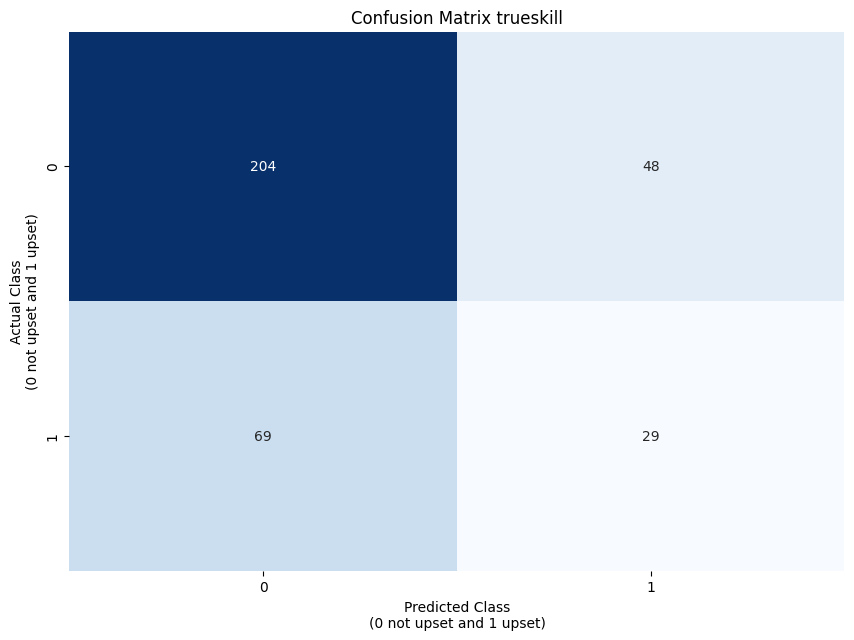

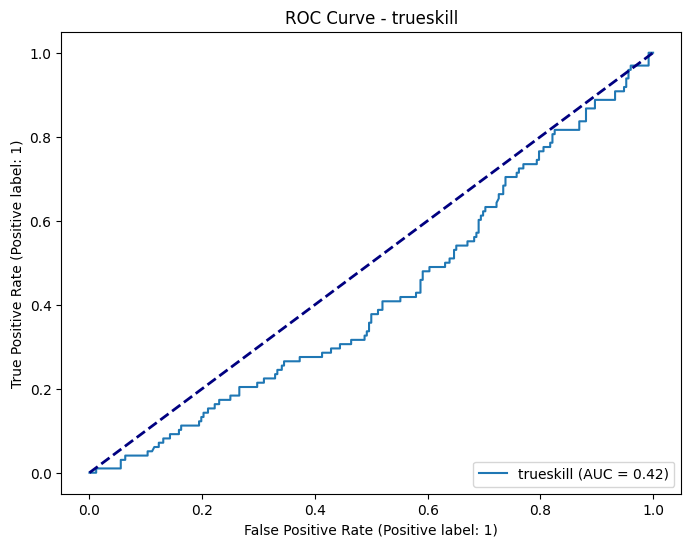

In [11]:
# Trueskill Ratings
ratings_model = 'trueskill'
ratings_function = trueskill_ratings
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [12]:
# Load all ranks df to Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

# Load confusion matrix df to Big Query
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_confusion_matrix_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_results_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')



100%|██████████| 1/1 [00:00<00:00, 6574.14it/s]


In [13]:
# Rank Aggregation functions called after ratings function have run and results inserted into Big Query

def borda_count_aggregation (fold_counter):

    from google.cloud import bigquery

    # Authenticate using the loaded key
    credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    fold_number = fold_counter
    all_ranks = """
              select * from analysis_layer.ratings_model_ranks
              """

    all_ranks_df = client.query(all_ranks).to_dataframe()
    all_ranks_df_fold = all_ranks_df[all_ranks_df['fold_number'] == fold_number].sort_values('team_no', ascending=True)
    all_ranks_df_fold['rank_total'] = all_ranks_df_fold[['basic_position','massey','colley','keener','trueskill']].sum(axis=1)
    all_ranks_df_fold['overall_rank'] = all_ranks_df_fold['rank_total'].rank(method='first', ascending=True).astype(int)
    all_ranks_df_fold['rating'] = 1 / all_ranks_df_fold['overall_rank']


    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(all_ranks_df_fold['team_no'], all_ranks_df_fold['rating']))

    return ratings

def average_rank_aggregation (fold_counter):

    from google.cloud import bigquery

    # Authenticate using the loaded key
    credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    fold_number = fold_counter
    all_ranks = """
              select * from analysis_layer.ratings_model_ranks
              """

    all_ranks_df = client.query(all_ranks).to_dataframe()
    all_ranks_df_fold = all_ranks_df[all_ranks_df['fold_number'] == fold_number].sort_values('team_no', ascending=True)
    all_ranks_df_fold['rank_average'] = all_ranks_df_fold[['basic_position','massey','colley','keener','trueskill']].mean(axis=1)
    all_ranks_df_fold['overall_rank'] = all_ranks_df_fold['rank_average'].rank(method='first', ascending=True).astype(int)
    all_ranks_df_fold['rating'] = 1 / all_ranks_df_fold['overall_rank']
    display(all_ranks_df_fold)


    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(all_ranks_df_fold['team_no'], all_ranks_df_fold['rating']))

    return ratings


Fold 1/5
Train data size: 280
Test data size: 70
borda_count
<function borda_count_aggregation at 0x7c975008a9e0>
[(1, 0.5), (2, 0.3333333333333333), (3, 1.0), (4, 0.14285714285714285), (5, 0.2), (6, 0.16666666666666666), (7, 0.024390243902439025), (8, 0.1111111111111111), (9, 0.05555555555555555), (10, 0.25), (11, 0.02631578947368421), (12, 0.125), (13, 0.058823529411764705), (14, 0.045454545454545456), (15, 0.1), (16, 0.047619047619047616), (17, 0.05), (18, 0.07692307692307693), (19, 0.027777777777777776), (20, 0.0625), (21, 0.037037037037037035), (22, 0.03125), (23, 0.022727272727272728), (24, 0.09090909090909091), (25, 0.07142857142857142), (26, 0.02), (27, 0.04), (28, 0.08333333333333333), (29, 0.019230769230769232), (30, 0.038461538461538464), (31, 0.0196078431372549), (32, 0.03571428571428571), (33, 0.03333333333333333), (34, 0.02702702702702703), (35, 0.016666666666666666), (36, 0.041666666666666664), (37, 0.029411764705882353), (38, 0.05263157894736842), (39, 0.025641025641025

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,borda_count,1,505337,1,1,34,2,0.500000,0.027027,1,1,0,0,0.616087
2,borda_count,1,813766,27,2,2,1,0.040000,0.333333,2,2,0,0,0.572812
3,borda_count,1,1061075,2,1,26,2,0.333333,0.020000,2,2,0,0,0.577699
4,borda_count,1,1620324,2,1,50,3,0.333333,0.018868,2,2,0,0,0.577975
5,borda_count,1,817437,3,1,33,2,1.000000,0.033333,3,3,0,0,0.724455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,borda_count,5,1349449,61,5,46,3,0.016949,0.041667,46,46,0,0,0.506179
347,borda_count,5,836539,47,3,64,6,0.028571,0.015873,47,47,0,0,0.503175
348,borda_count,5,1061094,59,4,47,3,0.029412,0.028571,59,47,0,1,0.500210
349,borda_count,5,949974,64,4,48,3,0.015873,0.019231,48,64,1,0,0.500839


,accuracy
1,0.685714
2,0.742857
3,0.685714
4,0.728571
5,0.657143


,ratings_model,fold_number,team_no,rating,rank
320,borda_count,0,1,0.633333,1
0,borda_count,1,1,0.500000,2
4,borda_count,2,1,1.000000,1
2,borda_count,3,1,0.333333,3
1,borda_count,4,1,0.333333,3
...,...,...,...,...,...
317,borda_count,1,64,0.016129,62
316,borda_count,2,64,0.015625,64
318,borda_count,3,64,0.016393,61
315,borda_count,4,64,0.016129,62


Mean Upset Accuracy: 0.7000
Standard Deviation of Upset Accuracy: 0.0313
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
350 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,borda_count
0,1,0,1,1,2,10,1,1
1,1,1,1,2,1,10,1,2
2,1,2,1,2,1,4,1,1
3,1,3,1,1,5,10,3,3
4,1,4,1,1,4,15,2,3
...,...,...,...,...,...,...,...,...
379,64,1,64,50,63,52,62,62
380,64,2,64,61,64,60,64,64
381,64,3,64,55,61,53,57,61
382,64,4,64,54,63,55,61,62


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 

,metric_id,metric,basic_position,massey,colley,keener,trueskill,borda_count
0,1,Cross-validation Accuracy,0.720,0.657,0.671,0.677,0.666,0.700
1,2,Cross-validation Standard Deviation,0.007,0.043,0.038,0.039,0.026,0.031
2,3,Overall Accuracy,0.720,0.657,0.671,0.677,0.666,0.700
3,4,Confusion Matrix - True Negative (Class 0),252.000,208.000,209.000,220.000,204.000,228.000
4,5,Confusion Matrix - False Positive (Class 1),0.000,44.000,43.000,32.000,48.000,24.000
5,6,Confusion Matrix - False Negative (Class 0),98.000,76.000,72.000,81.000,69.000,81.000
6,7,Confusion Matrix - True Positive (Class 1),0.000,22.000,26.000,17.000,29.000,17.000
7,8,Precision (Class 0),0.720,0.732,0.744,0.731,0.747,0.738
8,9,Recall (Class 0),1.000,0.825,0.829,0.873,0.810,0.905
9,10,F1-score (Class 0),0.837,0.776,0.784,0.796,0.777,0.813


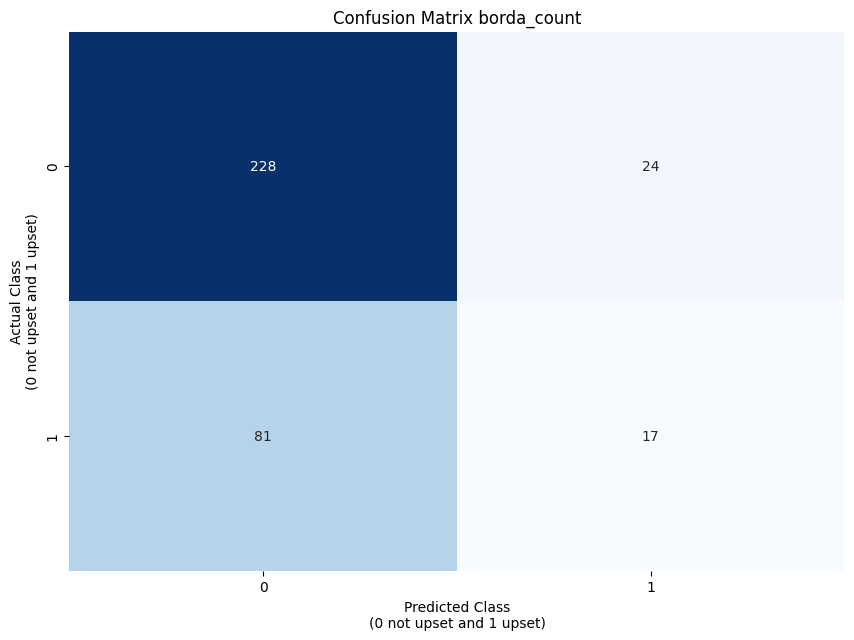

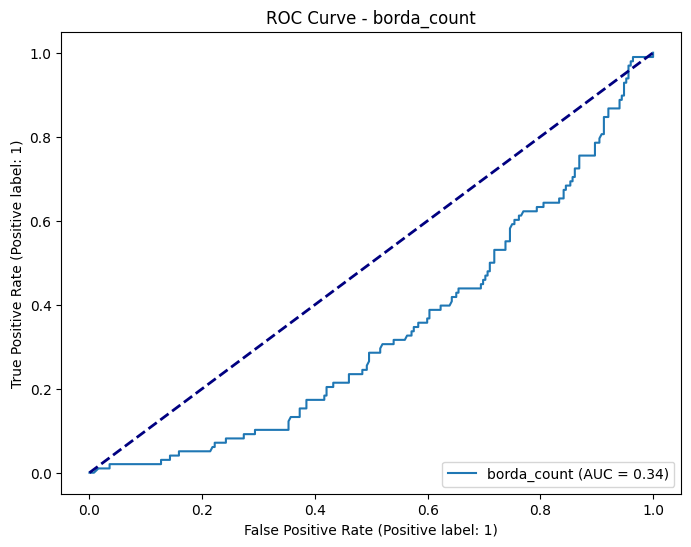

In [14]:
# Borda Count Aggregation
ratings_model = 'borda_count'
ratings_function = borda_count_aggregation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

print(results['all_actual_upsets'])
print(ratings_model)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

Fold 1/5
Train data size: 280
Test data size: 70
average_rank
<function average_rank_aggregation at 0x7c9741654ee0>


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
0,1,1,1,2,1,10,1,3.0,2,0.500000
9,2,1,2,3,6,7,5,4.6,3,0.333333
14,3,1,3,1,2,6,2,2.8,1,1.000000
20,4,1,4,4,7,8,15,7.6,7,0.142857
29,5,1,5,6,12,2,7,6.4,5,0.200000
...,...,...,...,...,...,...,...,...,...,...
355,60,1,60,63,56,46,52,55.4,58,0.017241
360,61,1,61,57,47,62,51,55.6,59,0.016949
370,62,1,62,55,53,54,56,56.0,61,0.016393
377,63,1,63,64,64,63,63,63.4,64,0.015625


[(1, 0.5), (2, 0.3333333333333333), (3, 1.0), (4, 0.14285714285714285), (5, 0.2), (6, 0.16666666666666666), (7, 0.024390243902439025), (8, 0.1111111111111111), (9, 0.05555555555555555), (10, 0.25), (11, 0.02631578947368421), (12, 0.125), (13, 0.058823529411764705), (14, 0.045454545454545456), (15, 0.1), (16, 0.047619047619047616), (17, 0.05), (18, 0.07692307692307693), (19, 0.027777777777777776), (20, 0.0625), (21, 0.037037037037037035), (22, 0.03125), (23, 0.022727272727272728), (24, 0.09090909090909091), (25, 0.07142857142857142), (26, 0.02), (27, 0.04), (28, 0.08333333333333333), (29, 0.019230769230769232), (30, 0.038461538461538464), (31, 0.0196078431372549), (32, 0.03571428571428571), (33, 0.03333333333333333), (34, 0.02702702702702703), (35, 0.016666666666666666), (36, 0.041666666666666664), (37, 0.029411764705882353), (38, 0.05263157894736842), (39, 0.02564102564102564), (40, 0.023809523809523808), (41, 0.023255813953488372), (42, 0.034482758620689655), (43, 0.025), (44, 0.01754

,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
1,1,2,1,2,1,4,1,1.8,1,1.000000
10,2,2,2,5,6,3,5,4.2,5,0.200000
15,3,2,3,1,2,7,4,3.4,3,0.333333
18,4,2,4,3,3,2,3,3.0,2,0.500000
24,5,2,5,6,4,1,2,3.6,4,0.250000
...,...,...,...,...,...,...,...,...,...,...
354,60,2,60,63,52,47,49,54.2,59,0.016949
361,61,2,61,49,54,64,59,57.4,61,0.016393
367,62,2,62,50,47,58,44,52.2,56,0.017857
376,63,2,63,64,62,63,61,62.6,63,0.015873


[(1, 1.0), (2, 0.2), (3, 0.3333333333333333), (4, 0.5), (5, 0.25), (6, 0.14285714285714285), (7, 0.024390243902439025), (8, 0.1), (9, 0.05555555555555555), (10, 0.16666666666666666), (11, 0.058823529411764705), (12, 0.125), (13, 0.06666666666666667), (14, 0.08333333333333333), (15, 0.07142857142857142), (16, 0.029411764705882353), (17, 0.09090909090909091), (18, 0.05), (19, 0.023255813953488372), (20, 0.1111111111111111), (21, 0.03125), (22, 0.03571428571428571), (23, 0.02127659574468085), (24, 0.047619047619047616), (25, 0.0625), (26, 0.02564102564102564), (27, 0.04), (28, 0.07692307692307693), (29, 0.021739130434782608), (30, 0.045454545454545456), (31, 0.02702702702702703), (32, 0.027777777777777776), (33, 0.02631578947368421), (34, 0.038461538461538464), (35, 0.018518518518518517), (36, 0.041666666666666664), (37, 0.03333333333333333), (38, 0.043478260869565216), (39, 0.030303030303030304), (40, 0.02040816326530612), (41, 0.02), (42, 0.022727272727272728), (43, 0.03225806451612903)

,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
5,1,3,1,1,5,10,3,4.0,3,0.333333
6,2,3,2,3,1,1,4,2.2,1,1.000000
16,3,3,3,2,2,6,1,2.8,2,0.500000
21,4,3,4,5,7,5,8,5.8,5,0.200000
26,5,3,5,4,9,3,5,5.2,4,0.250000
...,...,...,...,...,...,...,...,...,...,...
356,60,3,60,64,59,61,53,59.4,63,0.015873
365,61,3,61,57,64,63,64,61.8,64,0.015625
368,62,3,62,47,51,49,52,52.2,53,0.018868
374,63,3,63,62,56,57,56,58.8,62,0.016129


[(1, 0.3333333333333333), (2, 1.0), (3, 0.5), (4, 0.2), (5, 0.25), (6, 0.09090909090909091), (7, 0.034482758620689655), (8, 0.16666666666666666), (9, 0.045454545454545456), (10, 0.14285714285714285), (11, 0.043478260869565216), (12, 0.1), (13, 0.07692307692307693), (14, 0.125), (15, 0.0625), (16, 0.058823529411764705), (17, 0.07142857142857142), (18, 0.02631578947368421), (19, 0.03333333333333333), (20, 0.1111111111111111), (21, 0.02702702702702703), (22, 0.037037037037037035), (23, 0.022222222222222223), (24, 0.05263157894736842), (25, 0.06666666666666667), (26, 0.030303030303030304), (27, 0.03225806451612903), (28, 0.08333333333333333), (29, 0.029411764705882353), (30, 0.05), (31, 0.019230769230769232), (32, 0.04), (33, 0.03125), (34, 0.02564102564102564), (35, 0.017857142857142856), (36, 0.047619047619047616), (37, 0.025), (38, 0.05555555555555555), (39, 0.02), (40, 0.021739130434782608), (41, 0.027777777777777776), (42, 0.017241379310344827), (43, 0.020833333333333332), (44, 0.0204

,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
4,1,4,1,1,4,15,2,4.6,3,0.333333
7,2,4,2,2,2,1,1,1.6,1,1.000000
13,3,4,3,3,1,2,3,2.4,2,0.500000
22,4,4,4,4,7,4,7,5.2,5,0.200000
27,5,4,5,7,9,6,6,6.6,6,0.166667
...,...,...,...,...,...,...,...,...,...,...
359,60,4,60,64,64,59,64,62.2,64,0.015625
362,61,4,61,56,54,58,56,57.0,61,0.016393
366,62,4,62,46,44,47,43,48.4,49,0.020408
372,63,4,63,63,52,50,48,55.2,59,0.016949


[(1, 0.3333333333333333), (2, 1.0), (3, 0.5), (4, 0.2), (5, 0.16666666666666666), (6, 0.14285714285714285), (7, 0.023809523809523808), (8, 0.125), (9, 0.08333333333333333), (10, 0.25), (11, 0.05555555555555555), (12, 0.1111111111111111), (13, 0.06666666666666667), (14, 0.07692307692307693), (15, 0.0625), (16, 0.04), (17, 0.07142857142857142), (18, 0.043478260869565216), (19, 0.022222222222222223), (20, 0.1), (21, 0.030303030303030304), (22, 0.034482758620689655), (23, 0.02), (24, 0.05), (25, 0.05263157894736842), (26, 0.029411764705882353), (27, 0.047619047619047616), (28, 0.09090909090909091), (29, 0.02127659574468085), (30, 0.045454545454545456), (31, 0.02857142857142857), (32, 0.058823529411764705), (33, 0.037037037037037035), (34, 0.027777777777777776), (35, 0.0196078431372549), (36, 0.038461538461538464), (37, 0.02631578947368421), (38, 0.03571428571428571), (39, 0.019230769230769232), (40, 0.022727272727272728), (41, 0.023255813953488372), (42, 0.024390243902439025), (43, 0.02564

,team_no,fold_number,basic_position,massey,colley,keener,trueskill,rank_average,overall_rank,rating
2,1,5,1,1,1,8,1,2.4,1,1.000000
11,2,5,2,2,8,5,10,5.4,4,0.250000
17,3,5,3,4,2,6,3,3.6,2,0.500000
23,4,5,4,3,7,2,8,4.8,3,0.333333
28,5,5,5,8,10,1,6,6.0,6,0.166667
...,...,...,...,...,...,...,...,...,...,...
357,60,5,60,63,60,55,56,58.8,62,0.016129
363,61,5,61,56,54,60,55,57.2,59,0.016949
371,62,5,62,60,61,62,58,60.6,64,0.015625
373,63,5,63,61,53,59,54,58.0,61,0.016393


[(1, 1.0), (2, 0.25), (3, 0.5), (4, 0.3333333333333333), (5, 0.16666666666666666), (6, 0.08333333333333333), (7, 0.022222222222222223), (8, 0.09090909090909091), (9, 0.1), (10, 0.14285714285714285), (11, 0.07142857142857142), (12, 0.2), (13, 0.125), (14, 0.07692307692307693), (15, 0.05), (16, 0.05263157894736842), (17, 0.06666666666666667), (18, 0.043478260869565216), (19, 0.02702702702702703), (20, 0.1111111111111111), (21, 0.034482758620689655), (22, 0.03225806451612903), (23, 0.02), (24, 0.047619047619047616), (25, 0.05555555555555555), (26, 0.02564102564102564), (27, 0.045454545454545456), (28, 0.058823529411764705), (29, 0.023255813953488372), (30, 0.0625), (31, 0.01818181818181818), (32, 0.03571428571428571), (33, 0.03125), (34, 0.038461538461538464), (35, 0.017543859649122806), (36, 0.030303030303030304), (37, 0.023809523809523808), (38, 0.037037037037037035), (39, 0.022727272727272728), (40, 0.018867924528301886), (41, 0.02040816326530612), (42, 0.020833333333333332), (43, 0.03

,ratings_model,fold_number,match_id,home_team_no,home_team_league_level,away_team_no,away_team_league_level,home_team_rating,away_team_rating,predicted_winner,actual_winner,actual_upset,predicted_upset,upset_probability
1,average_rank,1,505337,1,1,34,2,0.500000,0.027027,1,1,0,0,0.616087
2,average_rank,1,813766,27,2,2,1,0.040000,0.333333,2,2,0,0,0.572812
3,average_rank,1,1061075,2,1,26,2,0.333333,0.020000,2,2,0,0,0.577699
4,average_rank,1,1620324,2,1,50,3,0.333333,0.018868,2,2,0,0,0.577975
5,average_rank,1,817437,3,1,33,2,1.000000,0.033333,3,3,0,0,0.724455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,average_rank,5,1349449,61,5,46,3,0.016949,0.041667,46,46,0,0,0.506179
347,average_rank,5,836539,47,3,64,6,0.028571,0.015873,47,47,0,0,0.503175
348,average_rank,5,1061094,59,4,47,3,0.029412,0.028571,59,47,0,1,0.500210
349,average_rank,5,949974,64,4,48,3,0.015873,0.019231,48,64,1,0,0.500839


,accuracy
1,0.685714
2,0.742857
3,0.685714
4,0.728571
5,0.657143


,ratings_model,fold_number,team_no,rating,rank
320,average_rank,0,1,0.633333,1
0,average_rank,1,1,0.500000,2
4,average_rank,2,1,1.000000,1
2,average_rank,3,1,0.333333,3
1,average_rank,4,1,0.333333,3
...,...,...,...,...,...
317,average_rank,1,64,0.016129,62
316,average_rank,2,64,0.015625,64
318,average_rank,3,64,0.016393,61
315,average_rank,4,64,0.016129,62


Mean Upset Accuracy: 0.7000
Standard Deviation of Upset Accuracy: 0.0313
Big Query target predictions table analysis_layer.ratings_predictions rows deleted: 305
350 rows appended to predictions table analysis_layer.ratings_predictions successfully.
Big Query target ratings table analysis_layer.ratings rows deleted: 384
384 rows appended to ratings table analysis_layer.ratings successfully.


,team_no,fold_number,basic_position,massey,colley,keener,trueskill,borda_count,average_rank
0,1,0,1,1,2,10,1,1,1
1,1,1,1,2,1,10,1,2,2
2,1,2,1,2,1,4,1,1,1
3,1,3,1,1,5,10,3,3,3
4,1,4,1,1,4,15,2,3,3
...,...,...,...,...,...,...,...,...,...
379,64,1,64,50,63,52,62,62,62
380,64,2,64,61,64,60,64,64,64
381,64,3,64,55,61,53,57,61,61
382,64,4,64,54,63,55,61,62,62


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 

,metric_id,metric,basic_position,massey,colley,keener,trueskill,borda_count,average_rank
0,1,Cross-validation Accuracy,0.720,0.657,0.671,0.677,0.666,0.700,0.700
1,2,Cross-validation Standard Deviation,0.007,0.043,0.038,0.039,0.026,0.031,0.031
2,3,Overall Accuracy,0.720,0.657,0.671,0.677,0.666,0.700,0.700
3,4,Confusion Matrix - True Negative (Class 0),252.000,208.000,209.000,220.000,204.000,228.000,228.000
4,5,Confusion Matrix - False Positive (Class 1),0.000,44.000,43.000,32.000,48.000,24.000,24.000
5,6,Confusion Matrix - False Negative (Class 0),98.000,76.000,72.000,81.000,69.000,81.000,81.000
6,7,Confusion Matrix - True Positive (Class 1),0.000,22.000,26.000,17.000,29.000,17.000,17.000
7,8,Precision (Class 0),0.720,0.732,0.744,0.731,0.747,0.738,0.738
8,9,Recall (Class 0),1.000,0.825,0.829,0.873,0.810,0.905,0.905
9,10,F1-score (Class 0),0.837,0.776,0.784,0.796,0.777,0.813,0.813


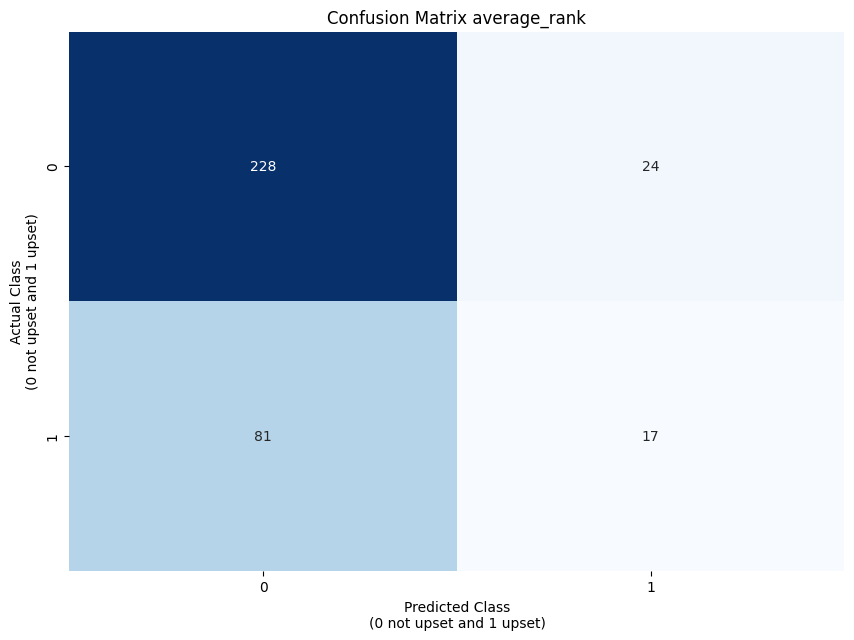

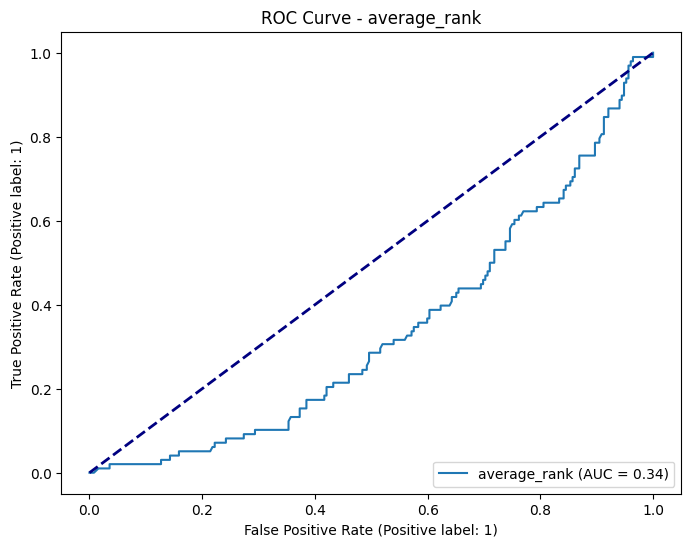

In [15]:
# Average Rank Aggregation
ratings_model = 'average_rank'
ratings_function = average_rank_aggregation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

print(results['all_actual_upsets'])
print(ratings_model)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

In [16]:
# Load updated all ranks df to Big Query so Borda Count can be subsequently queried in local kemeny optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

100%|██████████| 1/1 [00:00<00:00, 755.19it/s]


In [17]:
# Local Kemeny Optimisation

def local_kemeny_optimisation (fold_number, max_iterations=10):

    def kendall_tau_distance(ranking1, ranking2):
        distance = 0
        for i in range(len(ranking1)):
            for j in range(i + 1, len(ranking1)):
                if (ranking1[i] < ranking1[j]) != (ranking2[i] < ranking2[j]):
                    distance += 1
        return distance

    def total_kendall_tau_distance(candidate, rankings):
        return sum(kendall_tau_distance(candidate, ranking) for ranking in rankings.values())

    def local_kemeny_optimisation(rankings, initial_ranking, max_iterations):
        n_items = len(initial_ranking)

        current_ranking = initial_ranking.copy()
        current_distance = total_kendall_tau_distance(current_ranking, rankings)

        for iteration in range(max_iterations):
            improved = False
            for i in range(n_items - 1):
                new_ranking = current_ranking.copy()
                new_ranking[i], new_ranking[i+1] = new_ranking[i+1], new_ranking[i]
                new_distance = total_kendall_tau_distance(new_ranking, rankings)

                if new_distance < current_distance:
                    current_ranking = new_ranking
                    current_distance = new_distance
                    improved = True
                    print(f"Iteration {iteration + 1}: Improved distance to {current_distance}")
                    break

            if not improved:
                print(f"Stopped after {iteration + 1} iterations: No improvement")
                break

        if iteration == max_iterations - 1:
            print(f"Stopped after reaching maximum iterations ({max_iterations})")

        return current_ranking

    # Authenticate using the loaded key
    #credentials = service_account.Credentials.from_service_account_info(key)
    # Set up the BigQuery client with the credentials to project
    client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

    # Query to get the data
    all_ranks_query = f"""
        SELECT * FROM analysis_layer.ratings_model_ranks WHERE fold_number = {fold_number}
    """

    all_ranks_df = client.query(all_ranks_query).to_dataframe()

    # Create dictionary of rankings
    #rankings = {
    #    'basic_position': all_ranks_df['basic_position'].tolist(),
    #    'massey': all_ranks_df['massey'].tolist(),
    #    'colley': all_ranks_df['colley'].tolist(),
    #    'keener': all_ranks_df['keener'].tolist(),
    #    'trueskill': all_ranks_df['trueskill'].tolist()
    #}

    # Use Borda count as initial ranking
    borda_count = all_ranks_df['trueskill'].tolist()

    # Perform local Kemeny optimization
    optimized_ranking = local_kemeny_optimisation(rankings, borda_count, max_iterations)
    print("\nTotal Kendall tau distance (Borda Count):", total_kendall_tau_distance(borda_count, rankings))
    print("Total Kendall tau distance (Optimized):", total_kendall_tau_distance(optimized_ranking, rankings))

    # Show which teams changed positions
    team_nos = all_ranks_df['team_no'].tolist()

    # Create a mapping from team number to rank for both rankings
    borda_mapping = {team: rank for rank, team in enumerate(borda_count)}
    optimized_mapping = {team: rank for rank, team in enumerate(optimized_ranking)}

    changes = []
    for team in team_nos:
        borda_rank = borda_mapping.get(team, -1)
        optimized_rank = optimized_mapping.get(team, -1)
        if borda_rank != optimized_rank:
            changes.append((team, borda_rank, optimized_rank))

    print("\nTeams that changed positions (Team, Old Position, New Position):")
    for change in changes:
        print(f"Team {change[0]}: {change[1]} -> {change[2]}")

    # Create a DataFrame with the optimized ranking
    optimized_df = pd.DataFrame({
        'team_no': team_nos,
        'overall_rank': optimized_ranking
    })

    # Calculate the rating based on the optimized ranking
    optimized_df['rating'] = 1 / optimized_df['overall_rank']

    # Create a list of tuples in the format (team_no, rating) for function
    ratings = list(zip(optimized_df['team_no'], optimized_df['rating']))

    return ratings


In [18]:
# Local Kemeny Optimisation

ratings_model = 'local_kemeny_optimisation'
ratings_function = local_kemeny_optimisation
num_folds = 5

# Call ratings function and run cross validation
results = run_rating_models_cross_validation (fa_cup_scores_df, ratings_function, ratings_model, num_folds)

# Display results
display(results['predictions_df'])
display(results['upset_accuracy_scores_df'])
display(results['ratings_df'])
print(f"Mean Upset Accuracy: {results['mean_upset_accuracy']:.4f}")
print(f"Standard Deviation of Upset Accuracy: {results['std_upset_accuracy']:.4f}")

# Load predictions and ratinbgs to Google Big Query
predictions_df = results['predictions_df']
ratings_df = results['ratings_df']
load_predictions_and_ratings_to_bigquery(client, predictions_df, ratings_df, ratings_model)

# Create dataframe to compare rank and use for final rank aggregation
rank_df = ratings_df[['team_no', 'fold_number', 'rank']]
rank_df = rank_df.rename(columns={'rank': ratings_model})
all_ranks_df = all_ranks_df.merge(rank_df, on=['team_no','fold_number'], how='outer')
display(all_ranks_df)

# Create confusion matrix from results
results_df, cm_fig, roc_fig = create_model_results_df(results['all_actual_upsets'],results['all_predicted_upsets'], results['accuracies'], results['all_upset_probabilities'], ratings_model)
results_df = results_df.reset_index()
results_df['metric_id'] = results_df.index + 1
results_df = results_df[['metric_id', 'metric', ratings_model]]

all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')
display(all_results_df)

Fold 1/5
Train data size: 280
Test data size: 70
local_kemeny_optimisation
<function local_kemeny_optimisation at 0x7c9741393ac0>


NameError: name 'rankings' is not defined

In [ ]:
# Load final ranks including Local Kemeny Optimisation
load_dataset_name = 'analysis_layer'
load_table_name = 'ratings_model_ranks'
full_table_name = f"{load_dataset_name}.{load_table_name}"
pandas_gbq.to_gbq(all_ranks_df, full_table_name, project_id='birkbeck-msc-project-422917', if_exists='replace')

In [ ]:
# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df.to_excel("all_ranking_results.xlsx")